In [108]:
import numpy as np
import matplotlib.pyplot as plt
import nds2 
from astropy.time import Time
import time
import timeit
import sys
import scipy.signal as sig
from get_scan_coords import *
sys.path.append('hoak/')
import peakutils

OMC_chans = ['H1:OMC-DCPD_SUM_OUTPUT' , 'H1:OMC-DCPD_A_OUTPUT' , 'H1:OMC-DCPD_B_OUTPUT' , 'H1:OMC-PZT2_MON_DC_OUTPUT' , 'H1:OMC-PZT1_MON_DC_OUTPUT' , 'H1:OMC-PZT2_OFFSET' , 'H1:OMC-LSC_SERVO_GAIN' , 'H1:OMC-LSC_SERVO_INMON' , 'H1:OMC-LSC_SERVO_OUTPUT' , 'H1:GRD-OMC_LOCK_STATE_N']
TCS_chans = ['H1:TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT' , 'H1:TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT' , 'H1:TCS-ITMX_HWS_PROBE_SPHERICAL_POWER' , 'H1:TCS-ITMY_HWS_PROBE_SPHERICAL_POWER']
Pin_chan = 'H1:IMC-PWR_IN_OUT16'
darm_offset_chan  = ['H1:LSC-DARM1_OFFSET' , 'H1:LSC-DARM1_OUT16']#super small, might just want to find out when it is 0 and when it is not

ImportError: No module named peakutils

Note: H1:GRD-OMC_LOCK_STATE_N is in PREP_OMC_SCAN if the index is 140

In [2]:
# 2W to 5W to 10 W measurement (M1)
t_start = 1239402800
t_end  = 1239405898

#35W thermal state measurment (scan at 10W)
t2_start = 1239414600
t2_end = 1239415203

In [3]:
conn = nds2.connection('h1nds1', 8088)

In [29]:
# Fetching data from (M1)
print('Fetching data...') 
tic = timeit.default_timer()
data_M1 = conn.fetch(t_start, t_end, [OMC_chans[0], OMC_chans[3]])
data2_M1 = conn.fetch(t_start, t_end, [Pin_chan])
#data2 = conn.fetch(t_start, t_end, ['H1:PSL-POWER_SCALE_OFFSET.mean,s-trend', 'H1:GRD-ISC_LOCK_STATE_N.mean,s-trend', 'H1:TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT.mean,s-trend'])
toc = timeit.default_timer() - tic
print('Got data: Elapsed time = ' + str(round(toc,1)) + ' s')

Fetching data...
Got data: Elapsed time = 3.5 s


In [5]:
#Fetching data from (M2)
tic = timeit.default_timer()
data_M2 = conn.fetch(t2_start, t2_end, [OMC_chans[0]])
#data2 = conn.fetch(t_start, t_end, ['H1:PSL-POWER_SCALE_OFFSET.mean,s-trend', 'H1:GRD-ISC_LOCK_STATE_N.mean,s-trend', 'H1:TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT.mean,s-trend'])
toc = timeit.default_timer() - tic
print('Got data: Elapsed time = ' + str(round(toc,1)) + ' s')

Got data: Elapsed time = 0.5 s


In [33]:
#time series
f_s = data_M1[0].sample_rate
b = data_M1[0].data.shape[0]
t  = np.linspace(0, float(b)/float(f_s), b)
print(f_s)

16.0


In [86]:
PZT = data_M1[1].data
DCPD = data_M1[0].data #operating at low Z for these scans
PSL = data2_M1[0].data

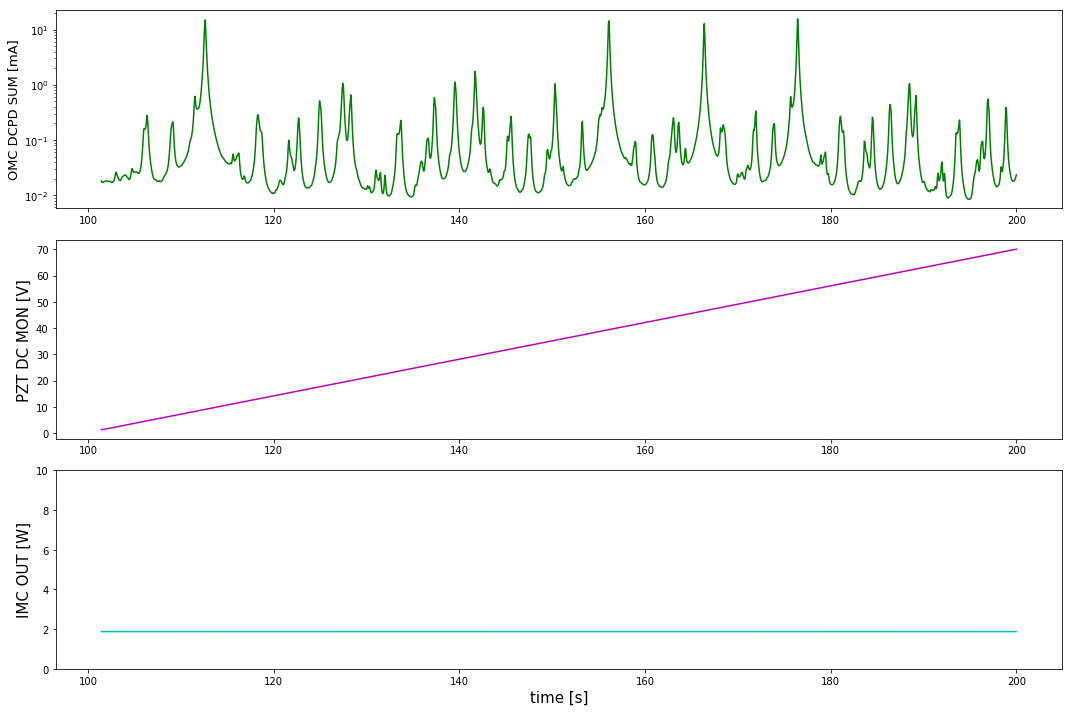

In [93]:
plt.figure(figsize=(15,10))
i = 1

plt.subplot(311)
plt.semilogy(t[a[i][0]:a[i][1]],DCPD[a[i][0]:a[i][1]],'g')
plt.ylabel('OMC DCPD SUM [mA]',FontSize='13')
#plt.title()

plt.subplot(312)
plt.plot(t[a[i][0]:a[i][1]],PZT[a[i][0]:a[i][1]],'m')
plt.ylabel('PZT DC MON [V]',FontSize='15')

plt.subplot(313)
plt.plot(t[a[i][0]:a[i][1]],PSL[a[i][0]:a[i][1]],'c')
plt.ylim([0,10])
plt.ylabel('IMC OUT [W]',FontSize='15')
plt.xlabel('time [s]',FontSize='15')
plt.tight_layout()

In [94]:
#Peak identification (characterizing the OMC)
FSR = 261710400.0
TMS = 57982266.0
fines = 375.5

In [98]:
def P_circ(nu, fines, fsr, P_max=1): 
    P = P_max/((1 +pow((2.0*fines/np.pi),2)*pow(np.sin((np.pi*nu)/fsr),2)))
    return P

In [103]:
nu = np.arange(.5*FSR, 2.5*FSR,10)
P = P_circ(nu, fines, FSR)

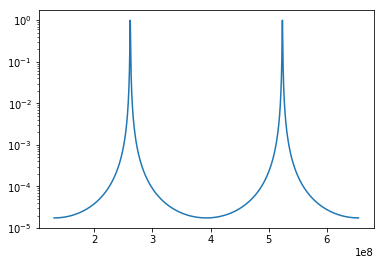

In [104]:
plt.semilogy(nu,P)

[ 179  875 1039 1200]


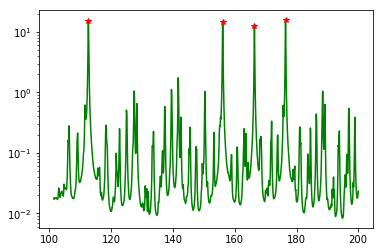

In [216]:
#Get the frequency to PZT voltage, to time conversion
#PZT to time
alpha = 70.0/100.0 # .7 volts/second
#PZT voltage to frequency (assuming it is linear over 1 FSR)
i=1
peaks_45MHz = sig.find_peaks(DCPD[a[i][0]:a[i][1]], height= 10.5)
print(peaks_45MHz[0])
k = 1
plt.semilogy(t[a[i][0]:a[i][1]],DCPD[a[i][0]:a[i][1]],'g')
peaks_45MHz = peaks_45MHz[0]+a[i][0]

for k in range(0,len(peaks_45MHz)):
    plt.semilogy(t[peaks_45MHz[k]],DCPD[peaks_45MHz[k]],'r*')

In [221]:
t_FSR  = (PZT[peaks_45MHz[3]]-PZT[peaks_45MHz[0]])/alpha

In [228]:
beta = (FSR)/t_FSR

In [229]:
#frequency to seconds
new_nu = [nu[i]/beta for i in range(0,len(nu))]

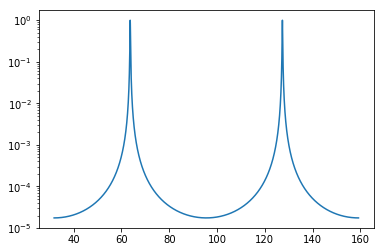

In [230]:
plt.semilogy(new_nu,P)